In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from ContactMechanics import PeriodicFFTElasticHalfSpace, FreeFFTElasticHalfSpace
from SurfaceTopography import Topography
from Adhesion.Interactions import Lj82, Exponential
from Adhesion.System import make_system
from Adhesion.System import BoundedSmoothContactSystem
from ContactMechanics.Tools.Logger import screen, Logger

In [4]:
nx, ny = 128,128
sx,sy= 250, 250
rho = 250/128

In [5]:
#Topography
x = np.arange(nx).reshape(-1,  1) * sx / nx - sx/2
y = np.arange(ny).reshape( 1, -1) * sy / ny - sy/2

topography= Topography(- np.sqrt(x**2 + y**2 ) *0.05, physical_sizes=(sx, sy) )

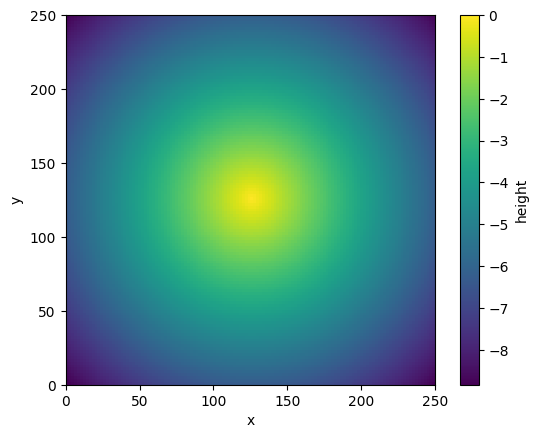

In [6]:
fig, ax = plt.subplots()

X, Y = np.meshgrid(np.arange(nx+1) * sx/nx, np.arange(ny+1) * sy/ny, indexing='ij') 
pcm = ax.pcolormesh(X,Y, topography.heights())
cb = plt.colorbar(pcm,ax= ax, label= "height")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

Text(0, 0.5, 'heights ($z_0$)')

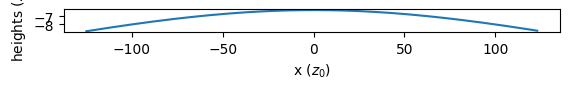

In [10]:
fig, ax = plt.subplots()
ax.plot(x, topography.heights()[:, 0])
ax.set_aspect(4.5)
ax.set_xlabel("x ($z_0$)")
ax.set_ylabel("heights ($z_0$)")

In [11]:
Es =  1 /  (2 * (1-0.3**2) / 230000)
alpha = 0.8
w = (alpha**2)*np.pi / 2

In [12]:
substrate = FreeFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))

In [13]:
interaction = Exponential(w, rho)

In [15]:
system = make_system(substrate= substrate,
    interaction=interaction,
    surface=Topography(- np.sqrt(x**2 + y**2 ) *0.05, physical_sizes=(sx, sy) ),
    system_class=BoundedSmoothContactSystem)

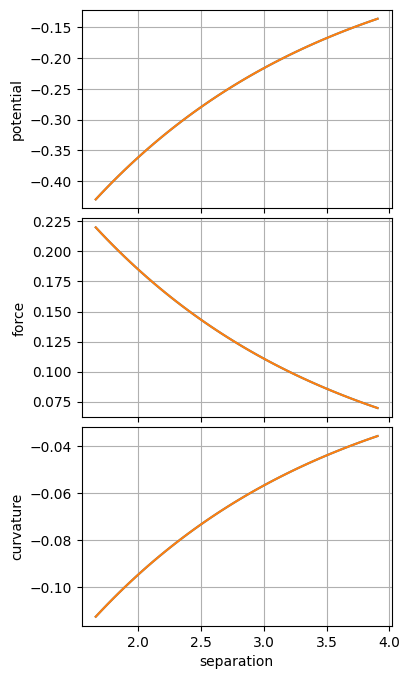

In [16]:
fig, ax = plt.subplots(3, sharex=True, figsize = (4,8))

z =np.linspace(0.85*rho,2*rho)
for poti in [Exponential(w, rho), system.interaction]:
    p,f,c = poti.evaluate(z, True, True, True)
    ax[0].plot(z,p)
    ax[1].plot(z,f)
    ax[2].plot(z,c)
    ax[0].set_ylabel("potential")
    ax[1].set_ylabel("force")
    ax[2].set_ylabel("curvature")
for a in ax:
    a.grid()
    
ax[2].set_xlabel("separation")
fig.subplots_adjust(hspace=0.05)

In [28]:
penetrations = np.linspace(-1, 2, 5)
penetrations = np.concatenate((penetrations, penetrations[-2::-1]))

In [29]:
gtol = 1e-3

In [30]:
normal_forces = []
repulsive_areas = []
forces = np.zeros((len(penetrations), *topography.nb_grid_pts))
disp0=None
i=0
for penetration in penetrations:
    print(f"penetration = {penetration}")
    sol = system.minimize_proxy(                                                                                                                              
        options=dict(gtol=gtol, # max absolute value of the gradient of the objective for convergence 
                     ftol=0, # stop only if the gradient criterion is fullfilled
                     maxcor=3 # number of gradients stored for hessian approximation
                    ),                               
        logger=Logger("laststep.log"),                                 
        offset=penetration,                                           
        callback=None,                                                 
                )
    assert sol.success, sol.message
    disp0 = u = system.disp # TODO: the disp0 should only include the elastic displacements. u contains ela
    normal_forces.append(system.compute_normal_force())
    repulsive_areas.append(system.compute_repulsive_contact_area())
    forces[i,...] = - system.substrate.evaluate_force(u)[system.substrate.topography_subdomain_slices]
    
    i+=1

penetration = -1.0
penetration = -0.25
penetration = 0.5
penetration = 1.25
penetration = 2.0
penetration = 1.25
penetration = 0.5
penetration = -0.25
penetration = -1.0


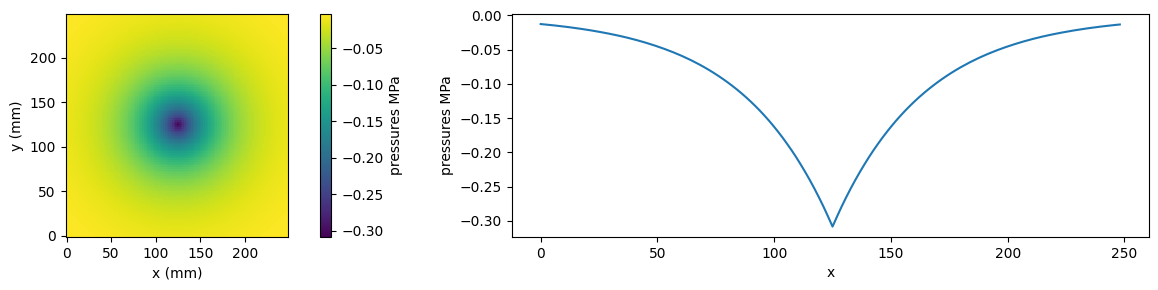

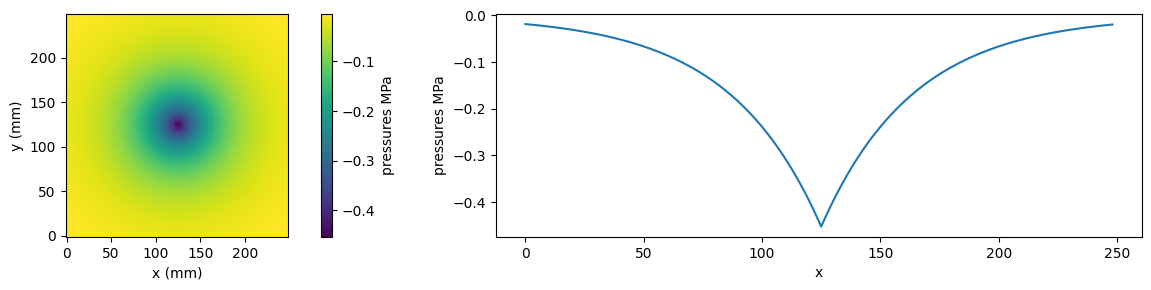

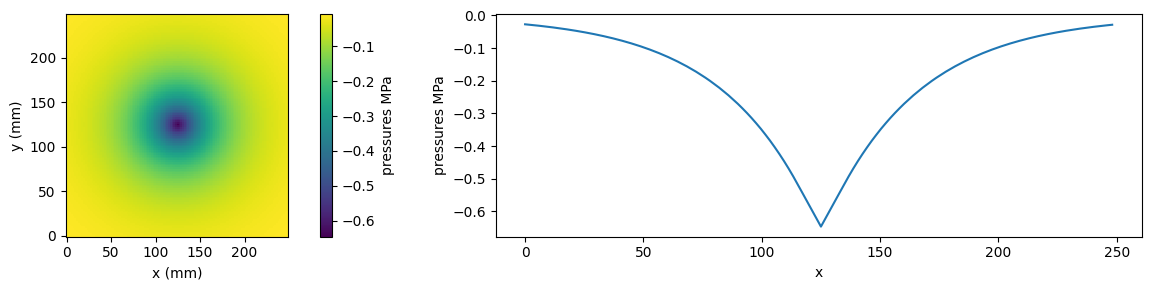

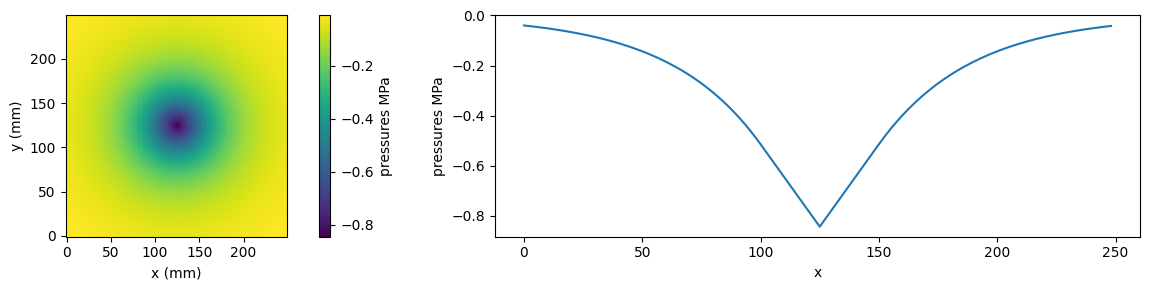

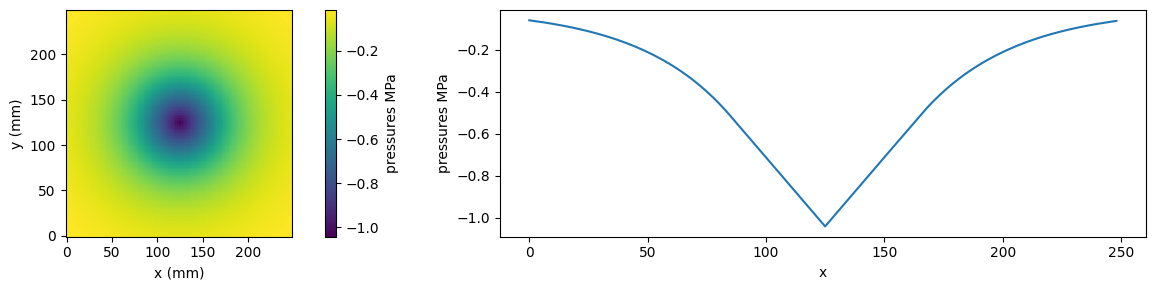

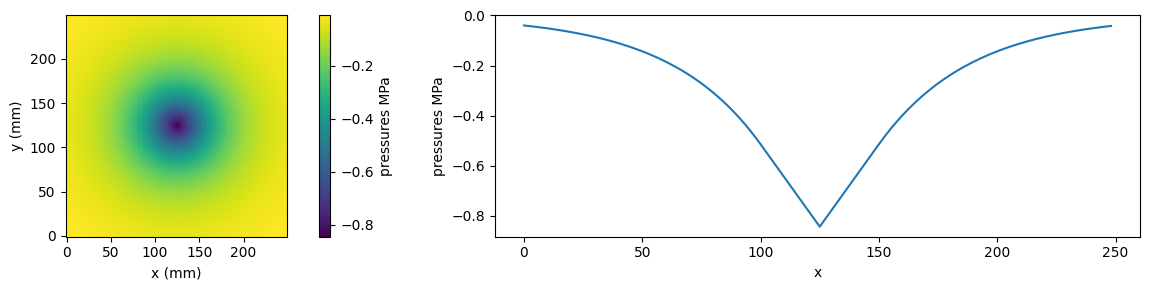

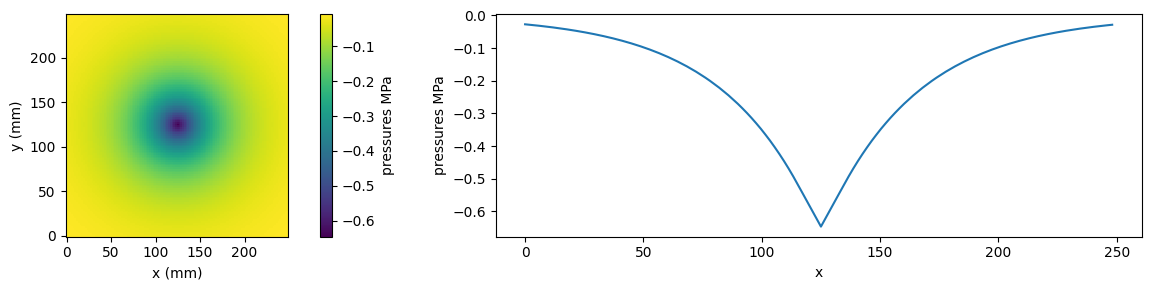

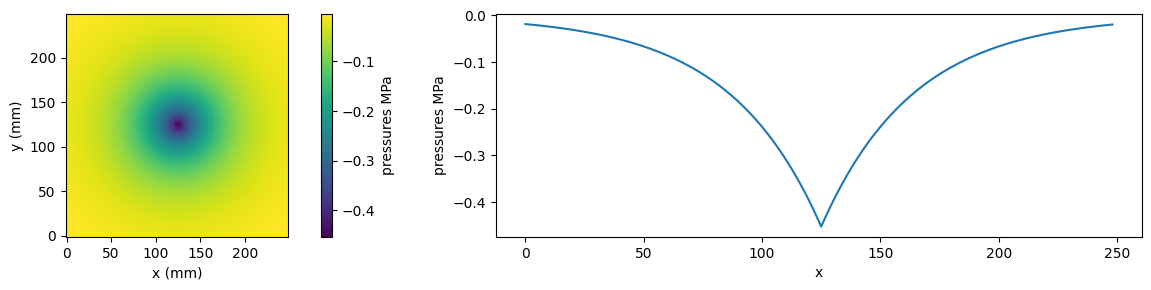

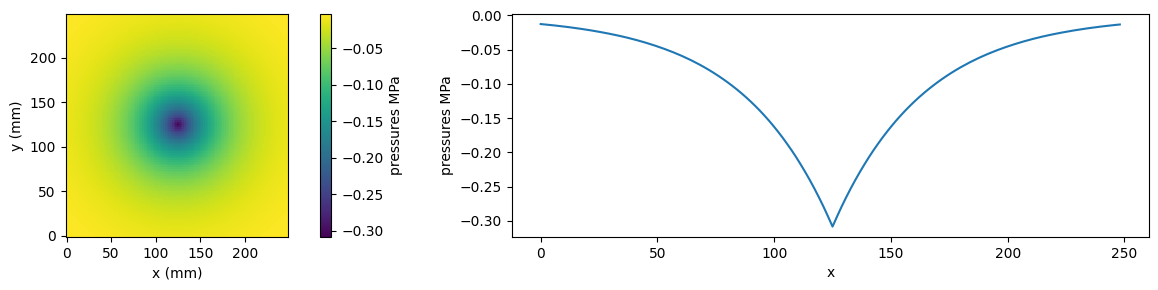

In [31]:
for i in range(len(penetrations)):
    
    fig, (axf, axfcut) = plt.subplots(1,2, figsize=(14,3))
    
    axf.set_xlabel("x (mm)")
    axf.set_ylabel("y (mm)")
        
    axfcut.plot(system.surface.positions()[0][:,0], forces[i, :, ny//2]/ system.area_per_pt)
    axfcut.set_xlabel("x")
    axfcut.set_ylabel("pressures MPa")
    
    
    
    plt.colorbar(axf.pcolormesh(*system.surface.positions(), forces[i,...]/ system.area_per_pt), label="pressures MPa", ax = axf)
    axf.set_aspect(1)
    
    
    
    fig.tight_layout()


Text(0, 0.5, 'Force [N]')

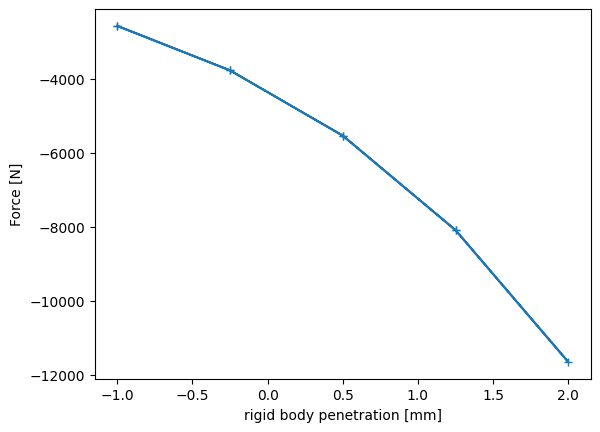

In [32]:
fig, ax = plt.subplots()

ax.plot(penetrations, normal_forces,"+-")
ax.set_xlabel("rigid body penetration [mm]")
ax.set_ylabel("Force [N]")